<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%EA%B5%AC%EC%A1%B0%EB%B3%80%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

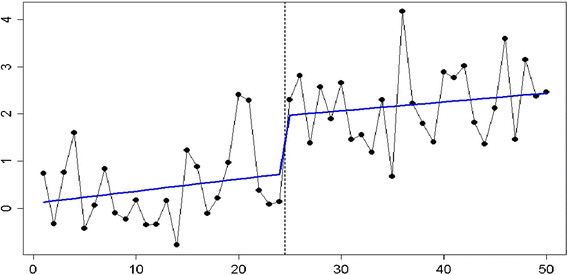

# 모듈을 불러오자

In [ ]:
!pip install arviz==0.6.1
!pip install pymc3==3.8

import arviz as az
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import theano.tensor as tt

# 포아송 카운트 모델

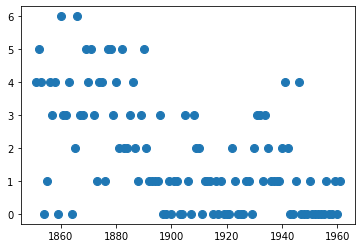

In [ ]:
# Coal Mine 사고발생수
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, 5, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, 3, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);


In [ ]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(),
                  upper=year.max(), testval=1900)

# Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

# Allocate appropriate Poisson rates to years before and after current
    rate = tt.switch(switchpoint >= year, early_rate, late_rate)
    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

In [ ]:
with disaster_model:
  trace = pm.sample(draws=2000, tune=1000, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling chain 0, 0 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1083.52it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


# 스위칭 리그레션

# 데이터를 불러오자

In [ ]:
x1 = np.linspace(0, 2, 50)
x2 = np.linspace(0, 2, 50)
x=np.hstack((x1,x2))

y1   = 0.5 + 1.5 * x1 + np.random.randn(50) * 0.2 
y2   = 0.5 + 2.5 * x1 + np.random.randn(50) * 0.1 
y=np.hstack((y1,y2))

index = np.arange(0, len(y))


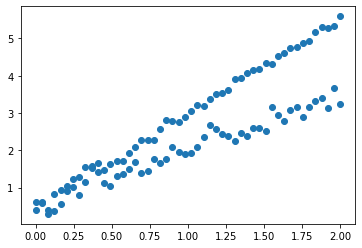

In [ ]:
plt.scatter(x, y)
plt.show()


# 모형 설정

In [ ]:
with pm.Model() as reg_model2:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=index.min(),
                  upper=index.max(), testval=50)

    # Priors
    alpha= pm.Normal("alpha", mu=0, sigma=2)   # 공통 절편 
    std1 = pm.Exponential("std1", lam=2)       
    std2 = pm.Exponential("std2", lam=2)
    beta1 = pm.Normal("beta1", mu=2, sigma=3)
    beta2 = pm.Normal("beta2", mu=2, sigma=3)

    beta = tt.switch(switchpoint >= index, beta1, beta2)
    std  = tt.switch(switchpoint >= index, std1, std2)

    # Likelihood 
    reg = pm.Normal('reg', mu=alpha+beta*x, sigma=std, observed=y)

# 사후표본추출

In [ ]:
with reg_model2:
  trace = pm.sample(draws=2000, tune=1000, chains=3)

Sequential sampling (3 chains in 1 job)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [beta2, beta1, std2, std1, alpha]
Sampling chain 2, 0 divergences: 100%|██████████| 3000/3000 [00:06<00:00, 499.92it/s]
The number of effective samples is smaller than 25% for some parameters.


# 결과 요약

In [ ]:
pm.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
switchpoint,1891.172,1.815,1890.00,1896.000,0.144,0.102,158.0,158.0,202.0,405.0,NaN
early_rate,3.101,0.269,2.57,3.576,0.008,0.005,1257.0,1257.0,1254.0,1133.0,NaN
late_rate,0.950,0.117,0.74,1.173,0.003,0.002,1534.0,1534.0,1513.0,1070.0,NaN


IndexError: ignored

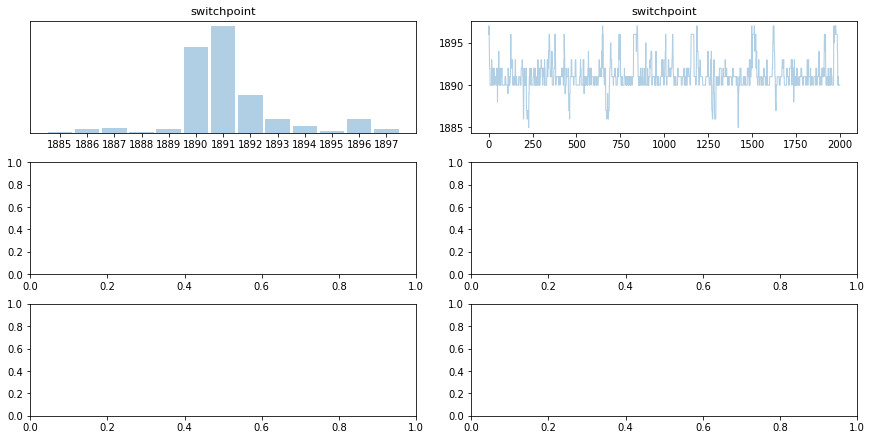

In [ ]:
import warnings
warnings.filterwarnings("ignore")
pm.traceplot(trace)